In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2025-09-25 03:53:51.763138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load test data #####

features_tradition = ['X_HH', 'iht', 'm_JJ', 'm_J1', 'm_J2', 'deta_JJ', 'J1_tau21', 'J2_tau21']
features_TDA = ['X_HH', 'iht', 'm_JJ', 'm_J1', 'm_J2', 'deta_JJ', 'J1_tau21', 'J2_tau21', 'H_0', 'H_1', 'SS_0', 'SS_1', 'LB_1']

target_2 = ['signal', 'background']
target_3 = ['signal', 'ttbarBG', 'jjBG']

test_path = '/root/data/test_data_HLfeature.h5'
test_file = h5py.File(test_path, 'r')

test_data_tradition = []
for feature in features_tradition:
    test_data_tradition.append(test_file[feature][:])
test_data_tradition = np.array(test_data_tradition).T
test_target = test_file['target2'][:]

test_data_TDA = []
for feature in features_TDA:
    test_data_TDA.append(test_file[feature][:])
test_data_TDA = np.array(test_data_TDA).T

print("shape of testing data with traditional variable:", np.shape(test_data_tradition))
print("shape of testing data with TDA variable:", np.shape(test_data_TDA))
print("shape of testing target:", np.shape(test_target))

shape of testing data with traditional variable: (159265, 8)
shape of testing data with TDA variable: (159265, 13)
shape of testing target: (159265,)


In [3]:
##### load DNN_model_tradition #####

DNN_model_tradition = load_model("/root/data/DNN_model_tradition_v1.h5")
prediction_tradition = DNN_model_tradition.predict(test_data_tradition)

sig_predict_tradition = prediction_tradition[0:102879, 0]
ttbarBG_predict_tradition = prediction_tradition[102879:102879+50065, 0]
jjBG_predict_tradition = prediction_tradition[102879+50065:, 0]

2025-09-25 03:53:54.720856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-09-25 03:53:54.721635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


 119/4978 [..............................] - ETA: 6s 

2025-09-25 03:53:56.182408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4978/4978 [==============================] - 7s 1ms/step


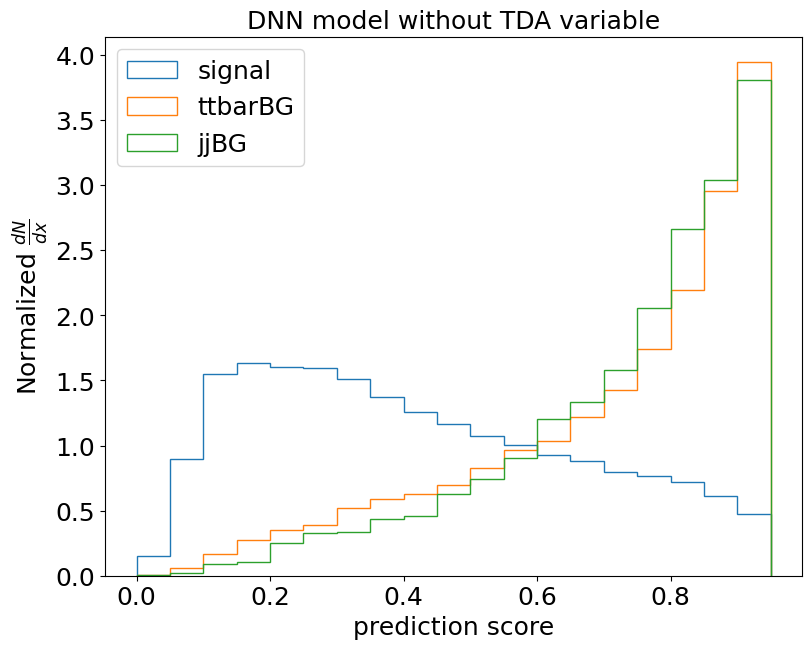

In [4]:
##### plot the prediction histogram #####

plt.figure(1, figsize=(9,7))
bins = np.arange(0,1,0.05)
plt.hist(sig_predict_tradition, bins=bins, label="signal", histtype='step', density=True)
plt.hist(ttbarBG_predict_tradition, bins=bins, label="ttbarBG", histtype='step', density=True)
plt.hist(jjBG_predict_tradition, bins=bins, label="jjBG", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
plt.title("DNN model without TDA variable", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [5]:
##### DNN_model_tradition selection #####

score_cut = 0.15

sig_selected_tradition = len(sig_predict_tradition[np.where(sig_predict_tradition<score_cut)])
ttbarBG_selected_tradition = len(ttbarBG_predict_tradition[np.where(ttbarBG_predict_tradition<score_cut)])
jjBG_selected_tradition = len(jjBG_predict_tradition[np.where(jjBG_predict_tradition<score_cut)])

##### calculate significance in Luminosity = 3000(fb^-1) #####

N_sim_sig = 200000
N_sim_ttbarBG = 200000
N_sim_jjBG = 1200000

Xsection_sig = 1.1086583
print("Before selection, the cross section of signal:", Xsection_sig, "(fb)")
Xsection_ttbarBG = 34166.61
print("Before selection, the cross section of ttbarBG:", Xsection_ttbarBG, "(fb)")
Xsection_jjBG = 60561410.45
print("Before selection, the cross section of jjBG:", Xsection_jjBG, "(fb)")
Xsection_jjBG_iht = 1526881.328

##### selection rate of DNN_model_tradition #####

print("\n########## Without TDA ##########")
print(sig_selected_tradition, "signal event pass DNN_model_tradition score", score_cut, ", selection rate:", sig_selected_tradition/len(sig_predict_tradition))
print(ttbarBG_selected_tradition, "ttbarBG event pass DNN_model_tradition score", score_cut, ", selection rate:", ttbarBG_selected_tradition/len(ttbarBG_predict_tradition))
print(jjBG_selected_tradition, "jjBG event pass DNN_model_tradition score", score_cut, ", selection rate:", jjBG_selected_tradition/len(jjBG_predict_tradition))

Luminosity = 3000    ### unit:fb^-1
print("\nIn Luminosity = 3000(fb^-1)")

s = Xsection_sig * (sig_selected_tradition/N_sim_sig) * Luminosity
b = Xsection_ttbarBG * (ttbarBG_selected_tradition/N_sim_ttbarBG) * Luminosity + Xsection_jjBG * (jjBG_selected_tradition/N_sim_jjBG) * Luminosity
significance = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
print("significance:", significance)

Before selection, the cross section of signal: 1.1086583 (fb)
Before selection, the cross section of ttbarBG: 34166.61 (fb)
Before selection, the cross section of jjBG: 60561410.45 (fb)

########## Without TDA ##########
13255 signal event pass DNN_model_tradition score 0.15 , selection rate: 0.1288406769117118
490 ttbarBG event pass DNN_model_tradition score 0.15 , selection rate: 0.009787276540497353
30 jjBG event pass DNN_model_tradition score 0.15 , selection rate: 0.004746084480303749

In Luminosity = 3000(fb^-1)
significance: 0.10068186209142094


In [6]:
##### load DNN_model_TDA #####

DNN_model_TDA = load_model("/root/data/DNN_model_TDA_v1.h5")
prediction_TDA = DNN_model_TDA.predict(test_data_TDA)

sig_predict_TDA = prediction_TDA[0:102879, 0]
ttbarBG_predict_TDA = prediction_TDA[102879:102879+50065, 0]
jjBG_predict_TDA = prediction_TDA[102879+50065:, 0]

4978/4978 [==============================] - 6s 1ms/step


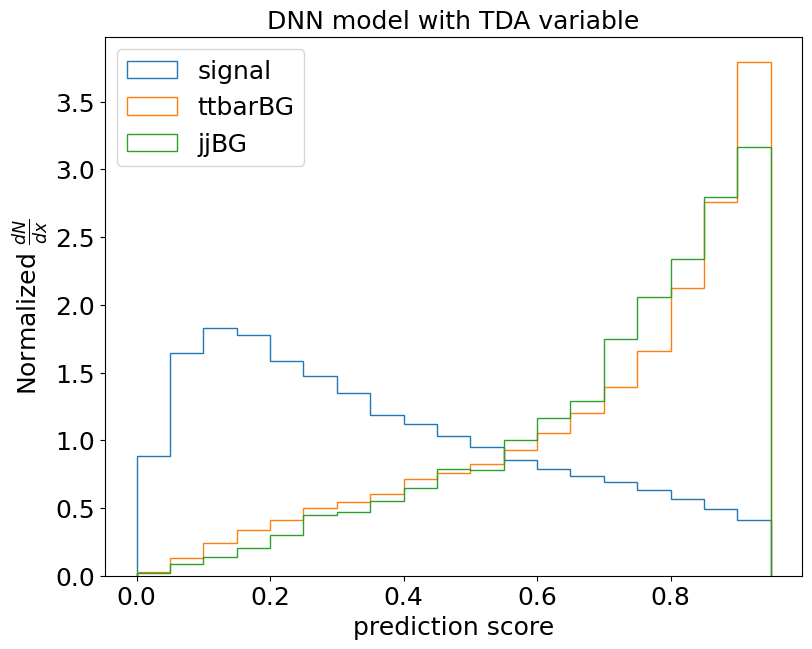

In [7]:
##### plot the prediction histogram #####

plt.figure(1, figsize=(9,7))
bins = np.arange(0,1,0.05)
plt.hist(sig_predict_TDA, bins=bins, label="signal", histtype='step', density=True)
plt.hist(ttbarBG_predict_TDA, bins=bins, label="ttbarBG", histtype='step', density=True)
plt.hist(jjBG_predict_TDA, bins=bins, label="jjBG", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
plt.title("DNN model with TDA variable", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [8]:
##### DNN_model_TDA selection #####

score_cut = 0.15

sig_selected_TDA = len(sig_predict_TDA[np.where(sig_predict_TDA<score_cut)])
ttbarBG_selected_TDA = len(ttbarBG_predict_TDA[np.where(ttbarBG_predict_TDA<score_cut)])
jjBG_selected_TDA = len(jjBG_predict_TDA[np.where(jjBG_predict_TDA<score_cut)])

##### calculate significance in Luminosity = 3000(fb^-1) #####

N_sim_sig = 200000
N_sim_ttbarBG = 200000
N_sim_jjBG = 1200000

Xsection_sig = 1.1086583
print("Before selection, the cross section of signal:", Xsection_sig, "(fb)")
Xsection_ttbarBG = 34166.61
print("Before selection, the cross section of ttbarBG:", Xsection_ttbarBG, "(fb)")
Xsection_jjBG = 60561410.45
print("Before selection, the cross section of jjBG:", Xsection_jjBG, "(fb)")
Xsection_jjBG_iht = 1526881.328

##### selection rate of DNN_model_TDA #####

print("\n########## With TDA ##########")
print(sig_selected_TDA, "signal event pass DNN_model_TDA score", score_cut, ", selection rate:", sig_selected_TDA/len(sig_predict_TDA))
print(ttbarBG_selected_TDA, "ttbarBG event pass DNN_model_TDA score", score_cut, ", selection rate:", ttbarBG_selected_TDA/len(ttbarBG_predict_TDA))
print(jjBG_selected_TDA, "jjBG event pass DNN_model_TDA score", score_cut, ", selection rate:", jjBG_selected_TDA/len(jjBG_predict_TDA))

Luminosity = 3000    ### unit:fb^-1
print("\nIn Luminosity = 3000(fb^-1)")

s = Xsection_sig * (sig_selected_TDA/N_sim_sig) * Luminosity
b = Xsection_ttbarBG * (ttbarBG_selected_TDA/N_sim_ttbarBG) * Luminosity + Xsection_jjBG * (jjBG_selected_TDA/N_sim_jjBG) * Luminosity
significance = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
print("significance:", significance)

Before selection, the cross section of signal: 1.1086583 (fb)
Before selection, the cross section of ttbarBG: 34166.61 (fb)
Before selection, the cross section of jjBG: 60561410.45 (fb)

########## With TDA ##########
22213 signal event pass DNN_model_TDA score 0.15 , selection rate: 0.21591384053110937
784 ttbarBG event pass DNN_model_TDA score 0.15 , selection rate: 0.015659642464795766
67 jjBG event pass DNN_model_TDA score 0.15 , selection rate: 0.010599588672678373

In Luminosity = 3000(fb^-1)
significance: 0.11375045619205136
